# Dataset: 
[Pima indians diabetes database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

Background literature review-

1. Brian et al(2011): Higher BMI increases the probability of getting diabetes.

2. Yan et al(2023): The prevalence of diabetes is higher in the elderly than in the middle-aged group.

3. Sasaki et al(2023): Insulin resistance is closely associated with glucose levels, and this relationship significantly impacts the probability of developing diabetes.

4. Emdin et al. (2015): People with elevated Blood Pressure are at increased risk of diabetes.

5. Peters et al(2017): A higher number of pregnancies were associated with a greater risk of diabetes.

6. Andrea et al(2020): Skinfold thickness and the incidence of type 2 diabetes mellitus and hypertension: an analysis of the PERU MIGRANT study

7. Junko et al(2016): Hyperglycemia Induces Skin Barrier Dysfunctions with Impairment of Epidermal Integrity in Non-Wounded Skin of Type 1 Diabetic Mice

Feature selection notes-


Study findings showed that skin thickness decreased as a result of type-2 diabetic progression. Skin thickness was significantly influenced by insulin level, but not glucose level.
Type-1 diabetics with high blood sugar (glucose) levels can have a high skin thickness instead. Since we don't have details regarding whether the patients suffer from Type1 or Type2 diabetes we can not infer much from this variable and it is best to drop it.

Due to the relation between insulin and glucose, we have also added an interaction term in our models which is the product of the two variables after normalization.


# EDA

In [1]:
# imports for data imputation
import random
import arviz as az
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.optimize
import pytensor.tensor as pt
from pathlib import Path
from matplotlib.lines import Line2D
from pymc.sampling.jax import sample_blackjax_nuts, sample_numpyro_nuts
from scipy.stats import multivariate_normal
from sklearn.preprocessing import MinMaxScaler


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
s:\anaconda\envs\bart\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./diabetes.csv")
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


$Outcome$ is a discrete variable with 0 for no diabetes and 1 for diabetes.


$Pregnancies$ is a discrete variable with the counts of Pregnancies.


$Glucose$ is a continuous variable measuring the glucose level in $mg/dL$ (milligrams per decilitre).


$Insulin$ is a continuous variable measuring the insulin level in most likely $pmol/L$ (picomoles per litre). 


$BloodPressure$ is a continuous variable measuring the blood pressure level in $mm$ $Hg$ (millimetres of Mercury).


$SkinThickness$ is a continuous variable measuring the thickness of skinfolds in $cm4 (centimetres). 


$BMI$ is a continuous variable measuring the body mass index in $kg/m^2$ (kilograms per metre squared).


$DiabetesPedigreeFunction$ is a continuous variable representing diabetes risk depending on the subject's age and his/her diabetic family history. It does not have a unit. 0.0 represents no risk and 2.42 is the maximum representing highest risk.


$Age$ is a continuous variable representing the age of the individuals although the values given are rounded to whole numbers.

In [3]:
# Define the outcome and predictors
bmi = df["BMI"]
age = df["Age"]
glucose = df["Glucose"]
insulin = df["Insulin"]
dpf = df["DiabetesPedigreeFunction"]
bp = df["BloodPressure"]
preg = df["Pregnancies"]
outcome = df["Outcome"]

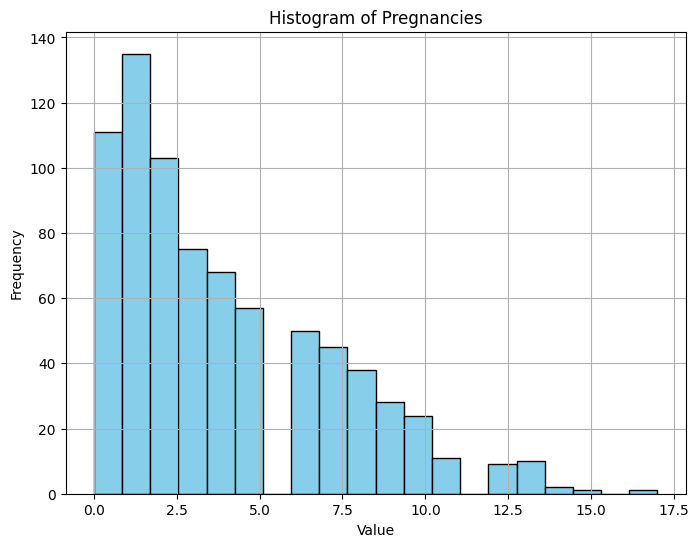

In [4]:
# Plotting the histograms
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(preg, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Pregnancies')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like a right skewed truncated normal distribution. Truncate at zero.

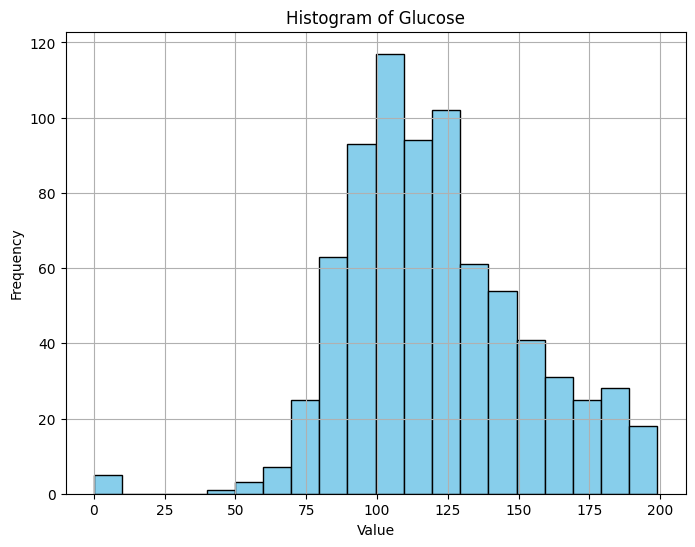

In [5]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(glucose, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Glucose')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()


looks like left skewed normal. missing values are zero but there shouldn't be any that low humanly possible.

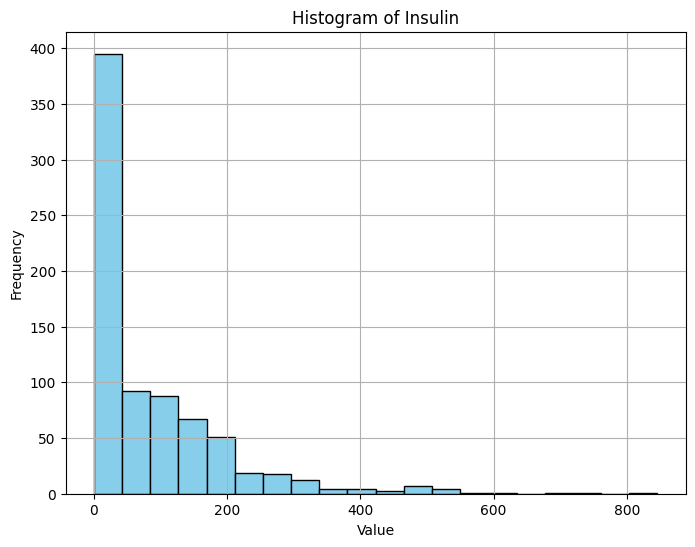

In [6]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(insulin, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Insulin')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like right skewed normal distribution. note that there are zero values which should be imputed. They are making it look like a heavier tail

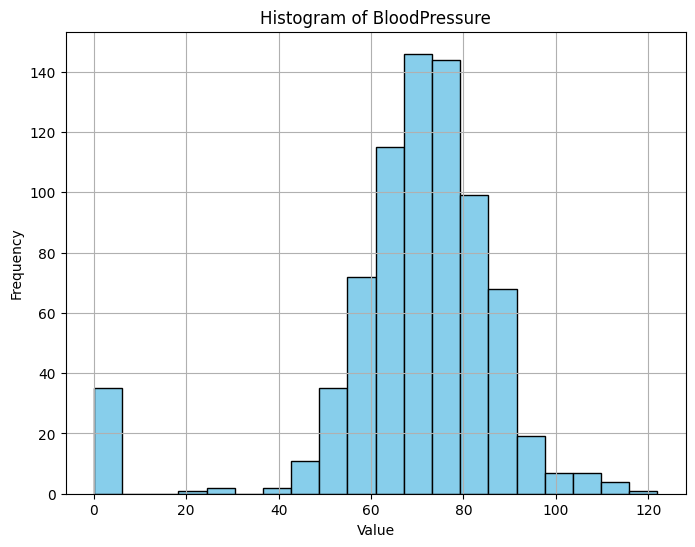

In [7]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(bp, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of BloodPressure')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like normal distribution, values at zero represent missing values

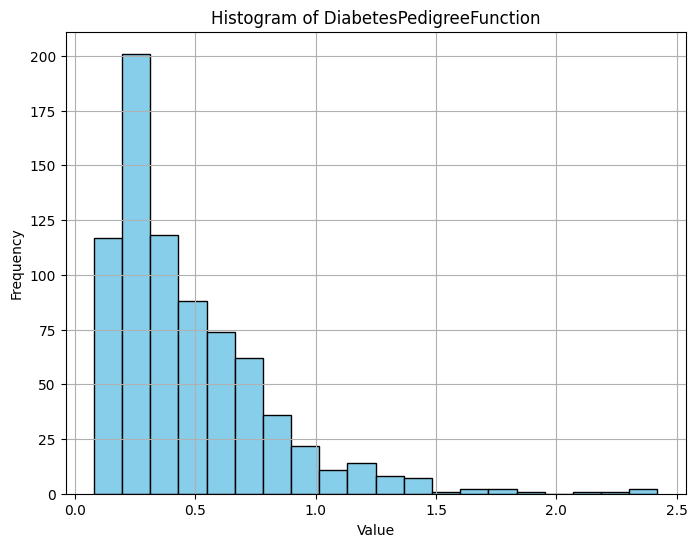

In [8]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(dpf, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of DiabetesPedigreeFunction')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like right skewed normal truncated at zero.

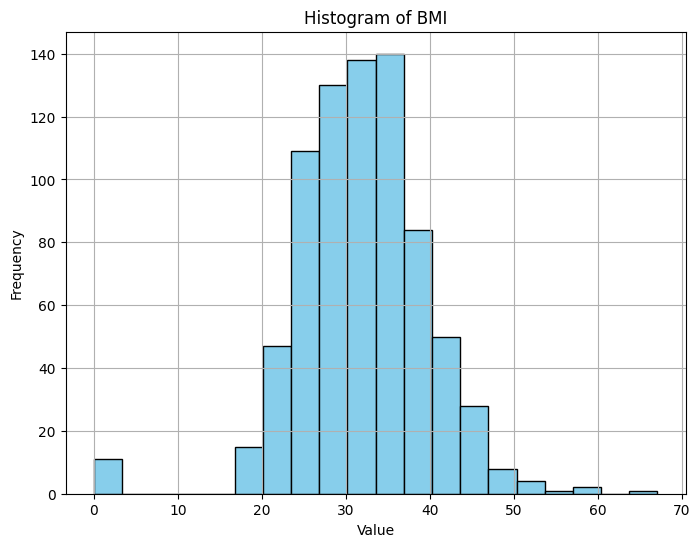

In [9]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(bmi, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of BMI')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like normal distribution. zero values are supposed to be missing values.

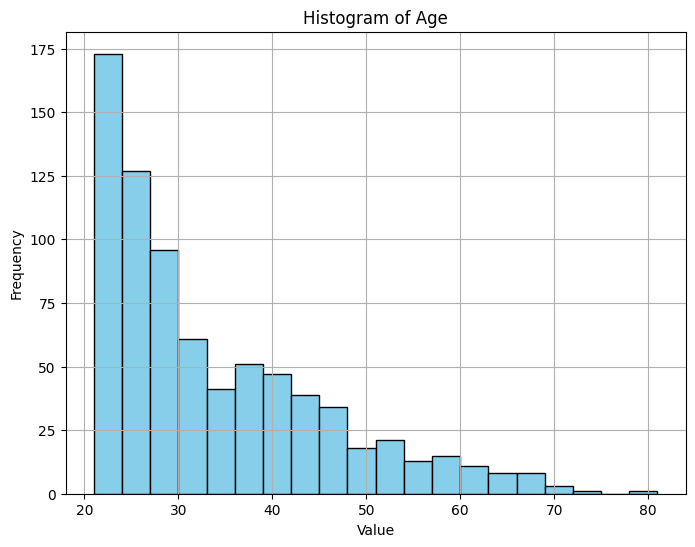

In [10]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(age, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Age')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like right skewed normal truncated at 21

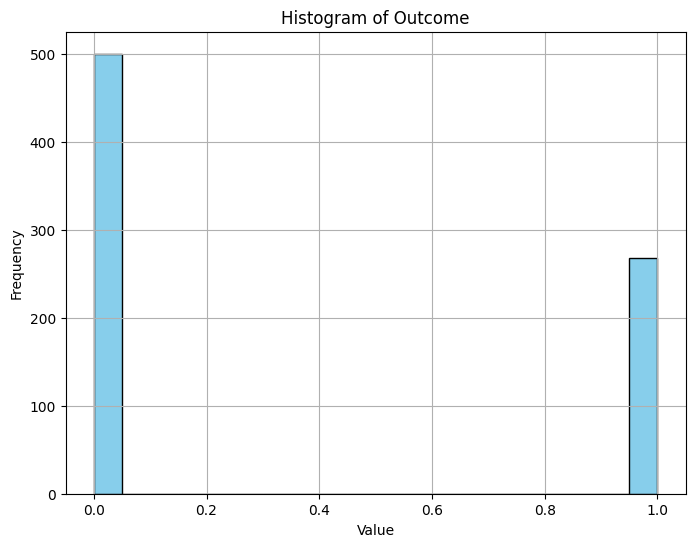

In [11]:
import math
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(outcome, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Outcome')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

Outcome is a Bernoulli random variable with P approximately equal to 0.34.

# DATA IMPUTATION
We used MICE algorithm for data imputation which is a frequentist technique because we didn't want to introduce more subjectivity in our model and we were unsure how it would affect the BART modelling process. 

MICE makes fewer assumptions about the underlying distribution for imputing data. If we had used the Bayesian equivalent method which is BICE and used strongly informative priors which were inaccurate then it would reduce BART model's performance significantly. 

It is important to note that there is an underlying assumption that the missing data is Missing Completely At Random or Missing At Random instead of Missing Not At Random which can only be modelled and imputed properly via bayesian methods.

The MICE algorithm is as follows:

1. Replace missing values with the column mean
   
2. Fix a column with missing values and fit a regression model on the 
remaining columns to predict the fixed column values

3. Predict missing value (which was set to mean initially) based on other 
columns and replace it.

4. Repeat for other columns
   
5. Repeat steps 2-4 for k iterations (often use k=5 in practice)


To perform this algorithm we first had to set all the zero values (except in Pregnancies and Outcome columns since they can take a value of zero) to $np.NaN$. 

This allowed us to prevent the missing values from affecting the mean and std which would've made our imputed values wildly incorrect due to the scales of the data. 

The MICE algorithm preserves the mean and variance in the dataset without the missing values throughout the iterations as we impute the missing values.

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

x = np.array([age, preg, dpf, glucose, insulin, bmi, bp])
x

array([[ 50.   ,  31.   ,  32.   , ...,  30.   ,  47.   ,  23.   ],
       [  6.   ,   1.   ,   8.   , ...,   5.   ,   1.   ,   1.   ],
       [  0.627,   0.351,   0.672, ...,   0.245,   0.349,   0.315],
       ...,
       [  0.   ,   0.   ,   0.   , ..., 112.   ,   0.   ,   0.   ],
       [ 33.6  ,  26.6  ,  23.3  , ...,  26.2  ,  30.1  ,  30.4  ],
       [ 72.   ,  66.   ,  64.   , ...,  72.   ,  60.   ,  70.   ]])

In [13]:
outcome = np.array(outcome)
type(outcome)

numpy.ndarray

In [14]:
# missing_cols = {"Glucose":3, "BloodPressure":5, "Insulin":4, "BMI":6}
value_to_replace = 0
mask = np.zeros(shape=(x.shape[0], x.shape[1]), dtype=bool)
print(x.shape)
for col in range(3,7):
    for i in range(len(x[0])):
        if x[col][i] == value_to_replace:
            x[col][i] = np.nan
            mask[col][i] = True
df = pd.DataFrame(x.T, columns=["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure"])
df.head() # verifying 0s have been replaced by NaN

(7, 768)


,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure
0,50.0,6.0,0.627,148.0,NaN,33.6,72.0
1,31.0,1.0,0.351,85.0,NaN,26.6,66.0
2,32.0,8.0,0.672,183.0,NaN,23.3,64.0
3,21.0,1.0,0.167,89.0,94.0,28.1,66.0
4,33.0,0.0,2.288,137.0,168.0,43.1,40.0


In [15]:
df.describe() # checking new descriptive stats

,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure
count,768.000000,768.000000,768.000000,763.000000,394.000000,757.000000,733.000000
mean,33.240885,3.845052,0.471876,121.686763,155.548223,32.457464,72.405184
std,11.760232,3.369578,0.331329,30.535641,118.775855,6.924988,12.382158
min,21.000000,0.000000,0.078000,44.000000,14.000000,18.200000,24.000000
25%,24.000000,1.000000,0.243750,99.000000,76.250000,27.500000,64.000000
50%,29.000000,3.000000,0.372500,117.000000,125.000000,32.300000,72.000000
75%,41.000000,6.000000,0.626250,141.000000,190.000000,36.600000,80.000000
max,81.000000,17.000000,2.420000,199.000000,846.000000,67.100000,122.000000


In [16]:
imputer = IterativeImputer(max_iter=5, random_state=0, skip_complete=True, sample_posterior=True, verbose=2) # number of iterations for MICE algorithm and seed value for reproducibility
imputed_values = imputer.fit_transform(x)

[IterativeImputer] Completing matrix with shape (7, 768)


[IterativeImputer] Ending imputation round 1/5, elapsed time 10.12
[IterativeImputer] Ending imputation round 2/5, elapsed time 20.05
[IterativeImputer] Ending imputation round 3/5, elapsed time 29.42
[IterativeImputer] Ending imputation round 4/5, elapsed time 39.63
[IterativeImputer] Ending imputation round 5/5, elapsed time 61.38


In [17]:
x[mask] = imputed_values[mask]
df = pd.DataFrame(x.T, columns=["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure"])

In [18]:
df.describe() # new stats after imputation. Mean and variance should be preserved

,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,33.240885,3.845052,0.471876,121.619741,152.223695,32.385355,72.151062
std,11.760232,3.369578,0.331329,30.500880,93.974674,6.937736,12.510370
min,21.000000,0.000000,0.078000,44.000000,12.654739,18.200000,24.000000
25%,24.000000,1.000000,0.243750,99.000000,94.634263,27.400000,64.000000
50%,29.000000,3.000000,0.372500,117.000000,135.000000,32.150000,72.000000
75%,41.000000,6.000000,0.626250,141.000000,185.261750,36.600000,80.000000
max,81.000000,17.000000,2.420000,199.000000,846.000000,67.100000,122.000000


## Normalizing data for faster convergence and better results

MCMC algorithms rely on efficient exploration of the parameter space to achieve convergence. Continuous variables with significantly different scales can lead to poor mixing, where the sampler gets stuck in regions of the space and fails to explore others effectively. 

Normalization puts all variables on a similar scale, allowing the sampler to move more fluidly across the space and explore different parameter values more efficiently. This improves the quality of the sampling process and leads to a more accurate representation of the posterior distribution. 

Normalization allows for direct comparison of the influence of different parameters on the model. This is because the coefficients in the model are interpreted in terms of standard deviation changes in the predictors.

Without normalization, the impact of a unit change in one variable might be vastly different from the impact of a unit change in another, making it difficult to interpret the relative importance of different factors.


Certain mathematical operations and statistical functions can become numerically unstable when dealing with variables of vastly different scales. Normalization helps prevent these issues by ensuring all variables are within a similar range, improving the numerical stability of the sampling process.

By addressing the issues mentioned above, normalization allows the MCMC sampler to converge on the target distribution more efficiently. This translates to faster runtime and a quicker achievement of reliable posterior estimates.

We used $0-1$ normalization for all variables except Age and Pregnancies. 

In [19]:
# normalizing all continuous variables
scaler = MinMaxScaler()
x = x.T
# Fit and transform only those columns
x_scaled = scaler.fit_transform(x)

In [20]:
age = x_scaled[:, 0]  # First feature (columns)
pregnancies = x[:, 1]
remaining_features_scaled = x_scaled[:, 2:]  # Features (columns) from index 2 onwards in x_scaled
print(remaining_features_scaled.shape)
age = age.reshape(age.shape[0], 1)
pregnancies = pregnancies.reshape(pregnancies.shape[0], 1)

print(age.shape, pregnancies.shape)
x_cont_var_normalized = np.concatenate([age.T, pregnancies.T, remaining_features_scaled.T], axis=0)

(768, 5)
(768, 1) (768, 1)


In [21]:
df = pd.DataFrame(x_cont_var_normalized.T, columns=["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure"])
df["Glucose_Insulin_Product"] = df["Glucose"] * df["Insulin"] # adding an interaction term as these quantities are highly correlated
df.describe()

,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure,Glucose_Insulin_Product
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.204015,3.845052,0.168179,0.500773,0.167480,0.290089,0.491337,0.098513
std,0.196004,3.369578,0.141473,0.196780,0.112768,0.141876,0.127657,0.101151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050000,1.000000,0.070773,0.354839,0.098374,0.188139,0.408163,0.034250
50%,0.133333,3.000000,0.125747,0.470968,0.146812,0.285276,0.489796,0.069304
75%,0.333333,6.000000,0.234095,0.625806,0.207125,0.376278,0.571429,0.123662
max,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.935484


# BART model

Bayesian Additive Regression Trees is a non-parametric regression approach introduced by Chipman et al [(2010). “BART: Bayesian additive regression trees.” The Annals of Applied Statistics, 4(1)]. 

It is the Bayesian equivalent of gradient boosting trees which are very popular and have been used to win several Kaggle competitions. 

BART performs bayesian model averaging (ensembling) on a large number of shallow(low depth) and sparse(low number of splits per level) decision trees.

The algorithm for this approach is as follows:

1. Recursive partitioning:
   
    a. Iterate through each feature (X) at each step.

    b. Choose the split point that minimizes an impurity 
    measure (like variance) for the target variable (y). This 
    creates two child nodes in our tree structure.
    
    c. Repeat splitting on the child nodes until a stopping 
    criteria is met (e.g., minimum number of data points in 
    a node or maximum number of nodes in tree). This creates a single decision tree.

2. Assign a constant value (average target variable) to each 
terminal node (leaf) of the tree. In our case this will be either 0 or 1 for the outcome variable in each of these.

3. Repeat Steps 1-2 m times. We often find $k = 50, 100, 200$ used in practice in literature involving BART. Therefore we used $k=50$ due to hardware constraints and also because we have a small dataset therefore a smaller value of $k$ is a form of regularization as this inherently limits the model's flexibility and reduces the chance of memorizing noise or irrelevant patterns.
   
4. Apply regularization based on prior node probabilities given by the hyperparameters alpha and beta. These parametrize the 
    probability that a node at depth $d(=0,1,2,...)$  is 
    non-terminal, given by $𝜶(1+d)^{-𝜷}$ 
    
5. Prediction for new data point:
   
    a. Obtain a prediction from each tree (the value assigned 
    to the terminal node where the data point lands).

    b. Use Bayesian Model Averaging (BMA) on the predictions from all trees in the 
    ensemble to get the final BART prediction for the new 
    data point.

In [22]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = "retina"

print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 5781
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Running on PyMC v5.12.0


# Training and Test data split

In [23]:

df2 = pd.DataFrame(outcome, columns=["Outcome"])
X = df.to_numpy()
Y = df2.to_numpy()
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

In [24]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)
print(Y_train.shape, Y_test.shape)

(614, 8) (614, 1) (154, 8) (154, 1)
(614,) (154,)


In [37]:
df3 = pd.DataFrame(X_train, columns=["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure", "Glucose_Insulin_Product"])
df3["Outcome"] = Y_train
df3.describe() 

,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure,Glucose_Insulin_Product,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.207248,3.889251,0.169497,0.497625,0.164956,0.292607,0.490115,0.096592,0.346906
std,0.196932,3.387548,0.145700,0.194787,0.109801,0.137821,0.128259,0.100356,0.476373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.004090,0.000000,0.000000,0.000000
25%,0.050000,1.000000,0.068851,0.354839,0.098192,0.191412,0.408163,0.034660,0.000000
50%,0.133333,3.000000,0.127028,0.470968,0.146812,0.290389,0.489796,0.068445,0.000000
75%,0.333333,6.000000,0.234308,0.617742,0.203211,0.374233,0.571429,0.119320,1.000000
max,1.000000,17.000000,1.000000,0.993548,1.000000,1.000000,1.000000,0.935484,1.000000


In [38]:
df4 = pd.DataFrame(X_test, columns=["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure", "Glucose_Insulin_Product"])
df4["Outcome"] = Y_test
df4.describe() 

,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure,Glucose_Insulin_Product,Outcome
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.191126,3.668831,0.162928,0.513322,0.177547,0.280050,0.496211,0.106170,0.357143
std,0.192348,3.301921,0.123476,0.204705,0.123767,0.157091,0.125522,0.104244,0.480721
min,0.000000,0.000000,0.002562,0.148387,0.004014,0.000000,0.061224,0.001140,0.000000
25%,0.033333,1.000000,0.075363,0.356452,0.098873,0.155930,0.428571,0.033913,0.000000
50%,0.116667,3.000000,0.123399,0.483871,0.146024,0.260736,0.489796,0.073408,0.000000
75%,0.295833,5.750000,0.232067,0.654839,0.210211,0.390082,0.571429,0.127985,1.000000
max,0.800000,14.000000,0.649872,1.000000,0.800803,0.752556,0.877551,0.625143,1.000000


# Model Training

In [30]:
with pm.Model() as diabetes_model:
    # BART model for predicted probability of diabetes
    x_data = pm.MutableData("x_data", X_train)
    y_data = Y_train
    μ = pmb.BART("μ", X=x_data, Y=y_data, m=50)   # m is number of subtrees. 50, 100 and 200 are common in practice
    # Define Bernoulli likelihood for the outcome
    p = pm.Deterministic("p", pm.math.sigmoid(μ))  # Map logit to probability (0-1)
    diabetes = pm.Bernoulli("diabetes", p=p, observed=y_data, shape=(x_data.shape[0],))
    idata_oos_regression = pm.sample(random_seed=RANDOM_SEED, draws=4000, tune=2000, chains=4)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 1706 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [diabetes]


# Convergence diagnostics

array([<Axes: xlabel='ESS'>, <Axes: xlabel='R-hat'>], dtype=object)

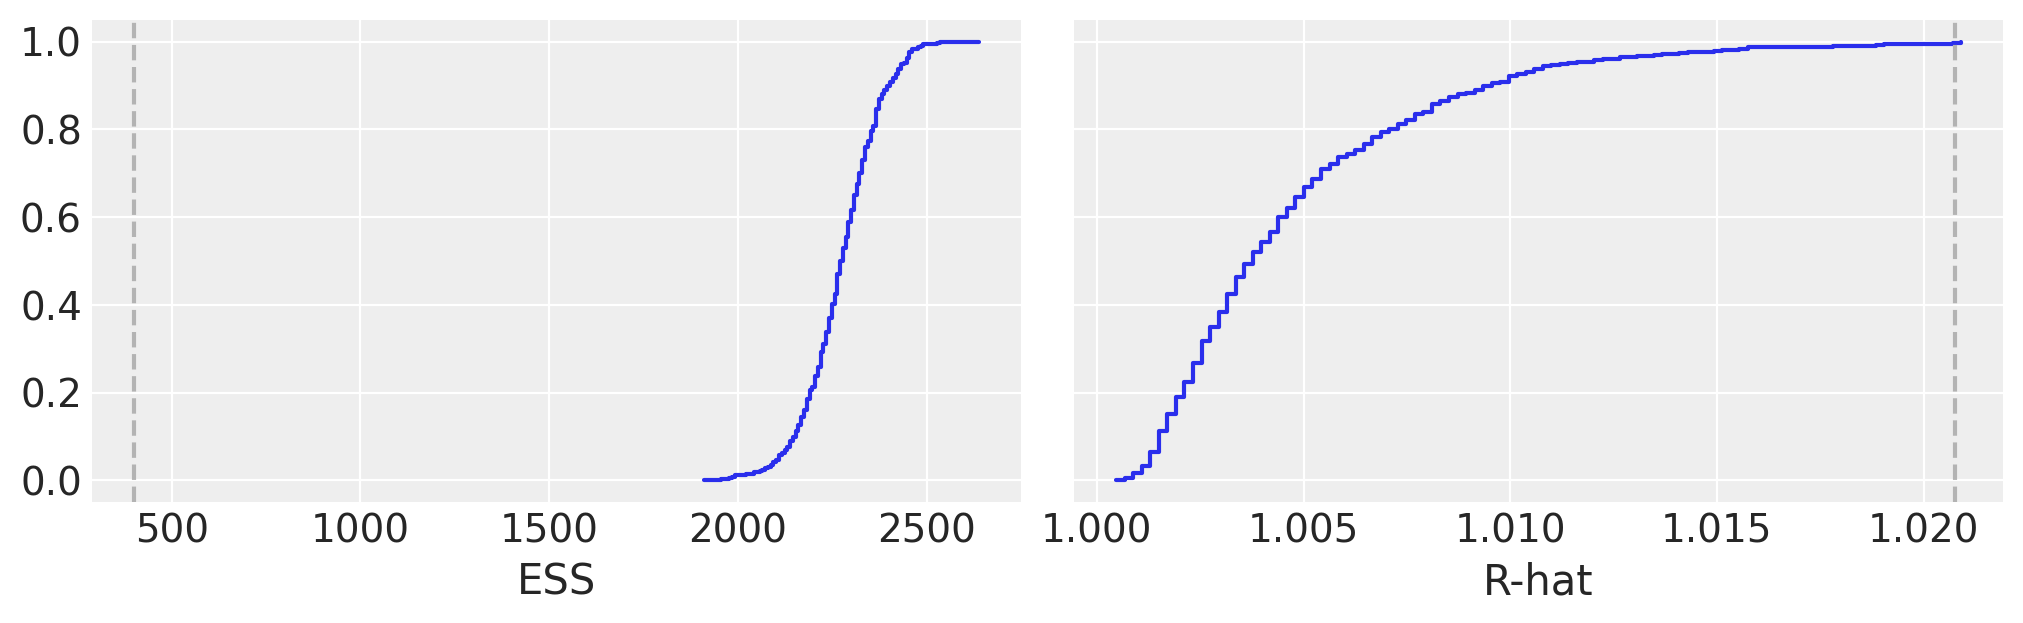

In [31]:
pmb.plot_convergence(idata_oos_regression, var_name="μ")

We have two panels one for ESS (Effective Sample Size) and one for the R-hat. 

The blue line is the empirical cumulative distribution for those values, for the ESS we want the curve to be on the right of the dashed line, and for R-hat we want the curve to be on the left the dashed line. 

In the above figure, we can see that we satisfy the ESS requirement for the entire curve and we satisfy the R-hat requirement for most of the curve. Very few values have an R-hat score greater than the threshold.


Although, in the BART literature, the diagnostics of the BART variables is sometimes considered less important than the diagnostics of the non-BART variables, the main argument is that the individual estimates of the latent variables are of no direct interest, and instead we should only care about how well we are estimating the whole function/regression.

# Individual Conditional Expectation plots

Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance’s prediction changes when a feature changes.

Partial dependence plots can obscure a heterogeneous relationship created by interactions which is why it is important to look at the ICE plots.

(30, 614, 1)
(30, 614, 1)
(30, 614, 1)
(30, 614, 1)
(30, 614, 1)
(30, 614, 1)
(30, 614, 1)
(30, 614, 1)


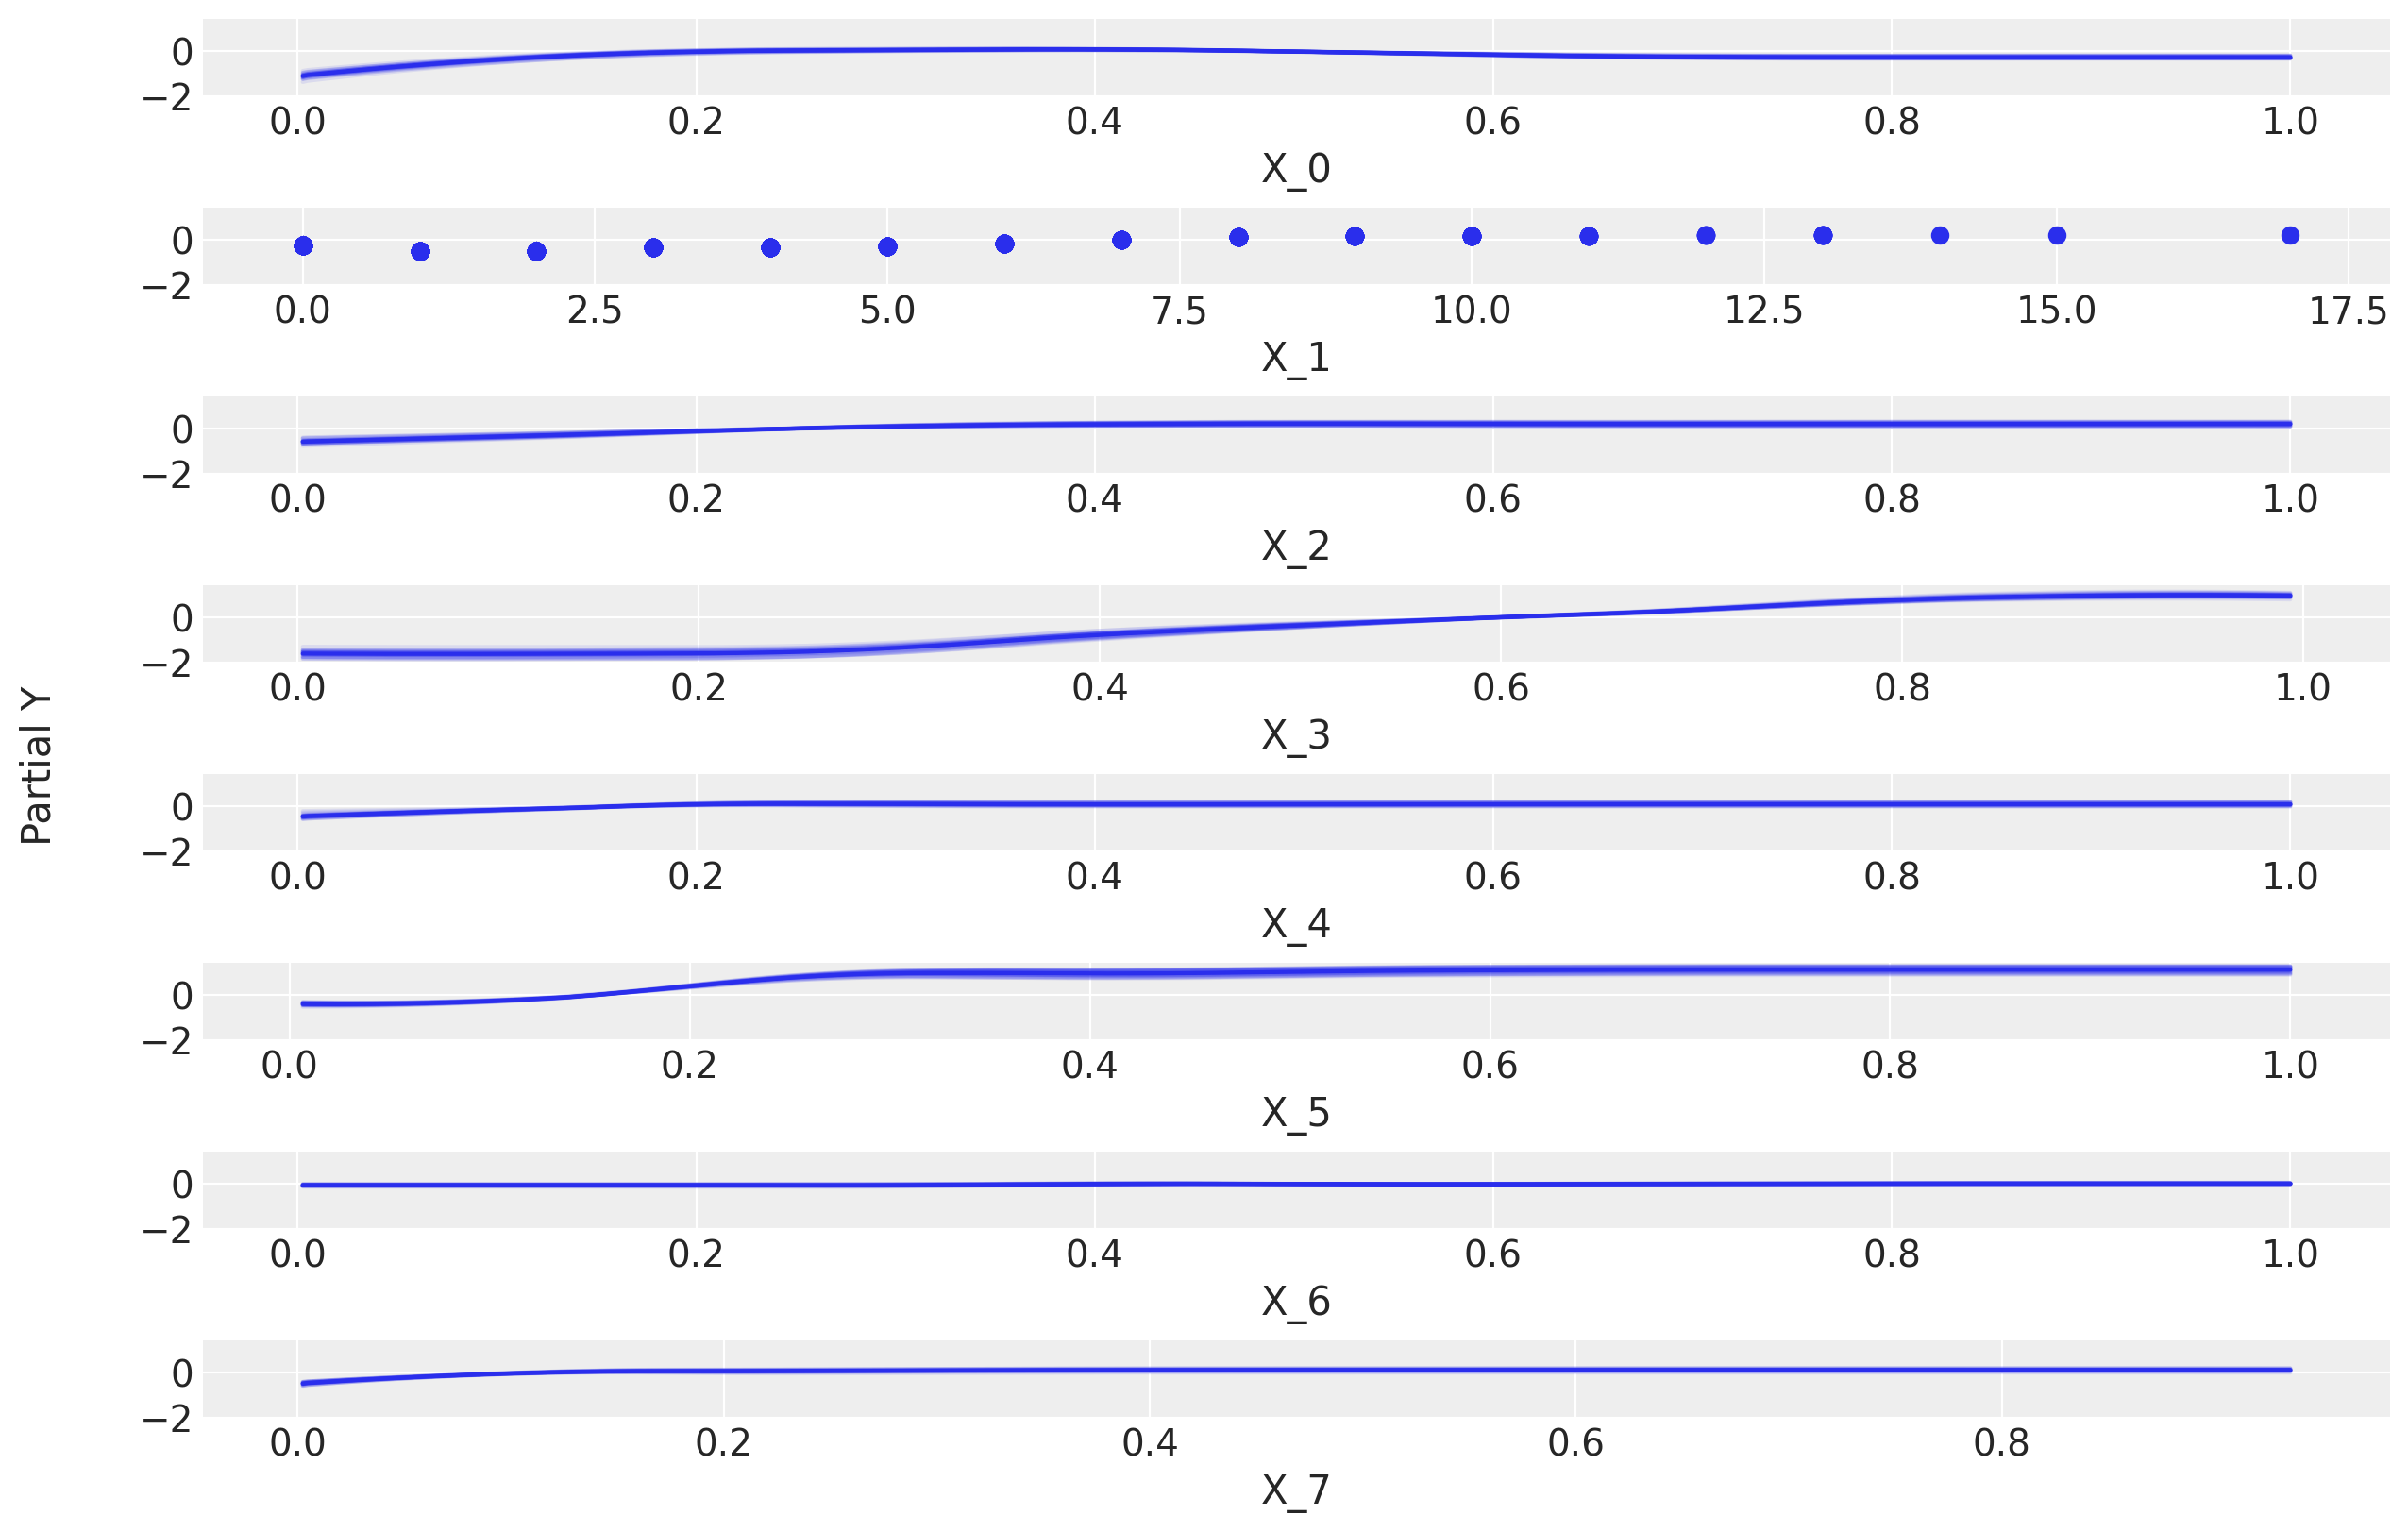

In [32]:
with diabetes_model:
    pmb.plot_ice(μ, X=X_train, Y=Y_train, var_discrete=[1], figsize=(12, 8))

Let us look at X_3 which is glucose for example. The plot shows that the outcome Y is close to 1 when normalized glucose level is higher than 0.8. It can be seen as having a negative contribution to the success of our outcome before 0.6.

Meanwhile X_4 which is insulin and X_6 which is Blood Pressure show almost 0 contribution to the outcome result for all possible values.



# Partial dependence plots
To help us interpret the results of our model we are going to use partial dependence plots. 

This is a type of plot that shows the marginal effect that one covariate has on the predicted variable. That is, what is the effect that a covariate $X_i$ has of $Y$ while we average over all the other covariates ( $X_j$ for all $j \neq i$).  

It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features. This is not true for all features in our dataset, which is why some graphs might look weird.

array([<Axes: xlabel='X_0'>, <Axes: xlabel='X_1'>, <Axes: xlabel='X_2'>,
       <Axes: xlabel='X_3'>, <Axes: xlabel='X_4'>, <Axes: xlabel='X_5'>,
       <Axes: xlabel='X_6'>, <Axes: xlabel='X_7'>], dtype=object)

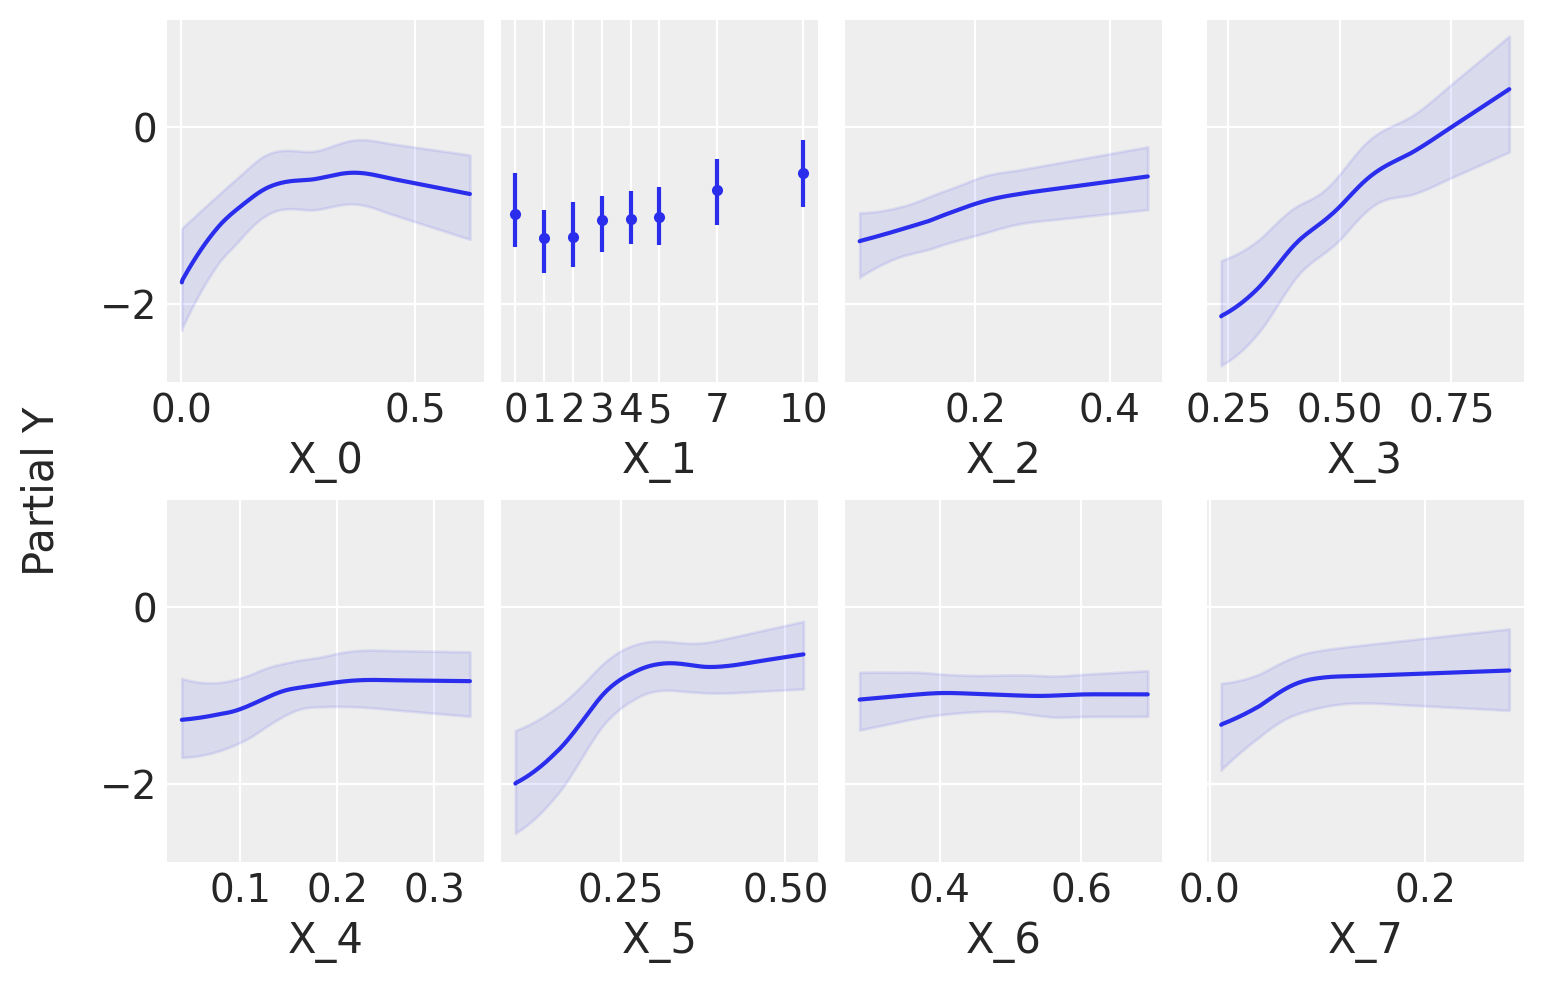

In [33]:
pmb.plot_pdp(μ, X=x_data, Y=y_data, grid=(2, 4), var_discrete=[1])

The partial dependence plots are the average of the lines of an ICE plot. 

X_3 which is Glucose for example shows a linaer relationship with the outcome, i.e. an increase in glucose levels results in the outcome turning into 1.

X_6 which is Blood Pressure on the other hand shows an almost constant line which suggests little effect on the outcome with an increase in blood pressure levels.

X_0 which is Age has a more complex relationship. The contribution to an outcome of 1 seems to be increasing (albeit still in the negatives so perhaps more apt to say the contribution to an outcome of 0 is decreasing) till around 0.3 after which it starts decreasing again. 

# Variable importance

The ranking of the variables is computed with a simple heuristic. We just count how many times a variable is included in all the regression trees. The intuition is that if a variable is important it should appear more often in the fitted trees than less important variables.

([3, 5, 0, 1, 2, 4, 7, 6], <Axes: ylabel='R²'>)

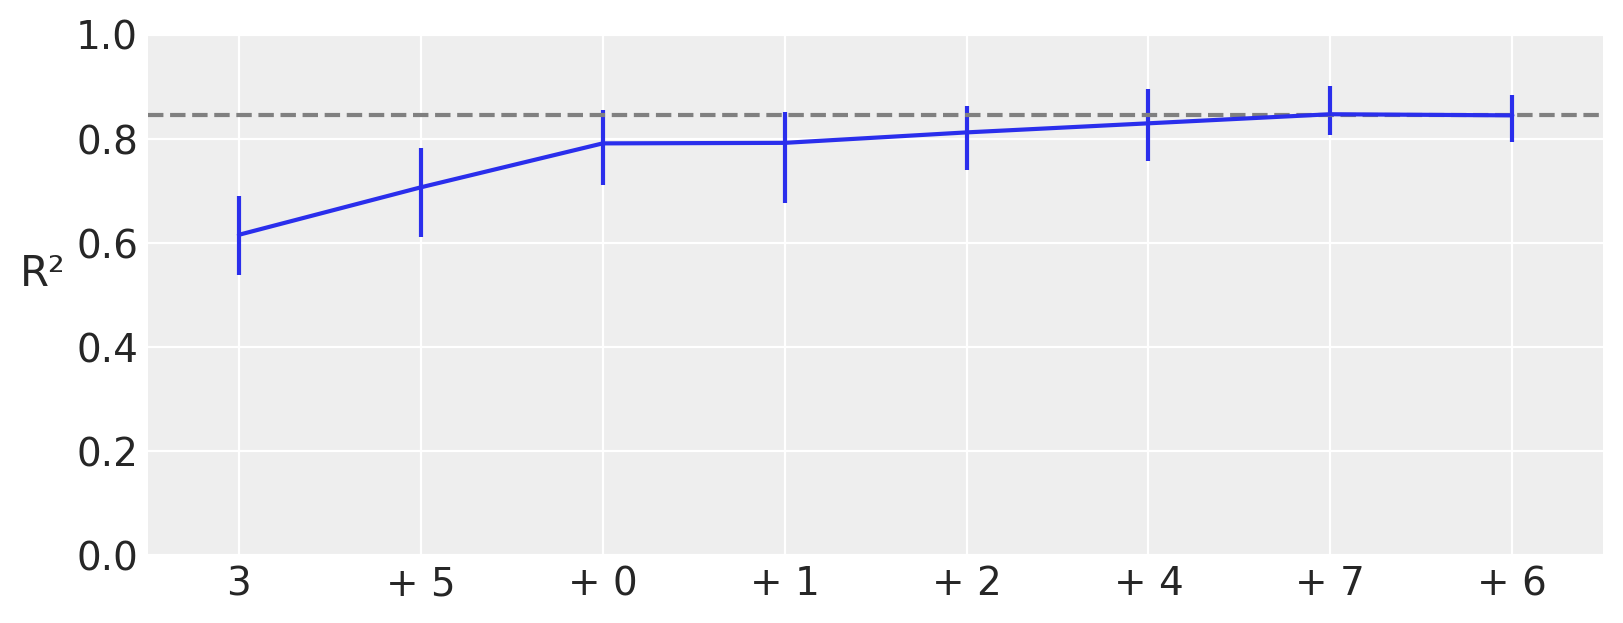

In [34]:
pmb.plot_variable_importance(idata_oos_regression, μ, X_train)

Age:0,	
Pregnancies:1,
DiabetesPedigreeFunction:2,
Glucose:3,
Insulin:4,
BMI:5,
BloodPressure:6,
Glucose_Insulin_Product:7


On the x-axis we have the number of covariables and on the y-axis R² (the the square of the Pearson correlation coefficient) between the predictions made for the full model (all variables included) and the restricted models, those with only a subset of the variables.

The most important variable is Glucose, then BMI, Age, Pregnancies, DiabetesPedigreeFunction, Insulin, Glucose_Insulin_Product and finally BloodPressure. 
The first value of R², is the value of a model that only includes the variable Glucose, the second R² is for a model with two variables, Glucose and BMI, and so on. 

Besides this ranking, we can see that even a model with six components Glucose, BMI, Age, Pregnancies, DiabetesPedigreeFunction, Insulin is on average indistinguishable from the full model. The error bars represent the 94 % HDI from the posterior predictive distribution.

This means that we should expect a model with only Glucose, BMI, Age, Pregnancies, DiabetesPedigreeFunction, Insulin to have a similar predictice performance than a model with all the variables.

Notice that our R² value drops for the full model which includes the the Blood Pressure feature. This matches our earlier results from the PDP plots showing little impact on outcome being successful with an increase in Blood Pressure. This explains the reduced R² score as blood pressure is essentially noise once we have the other six variables already for the prediction of diabetes.

While a model which includes the interaction term Glucose_Insulin_Product has a higher R² score and above the threshold, it must be noted that this difference is very small. This shows the power of BART model to learn interactions between features without explicitly including them and perhaps with a higher number of trees like 100 instead of 50 this interaction term would not have been necessary at all.

# Out-of-Sample Predictions
The core goal of any model is to make accurate predictions on unseen data.

Evaluating our out of sample predictive performance helps assess this generalizability and in choosing the best model for our specific prediction task. The model with the best out-of-sample performance is likely to generalize better to new data.

We use an 80% train 20% test split for our dataset. 



In [35]:
with diabetes_model:
    x_data.set_value(X_test)
    y_data = Y_test
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Sampling: [diabetes, μ]


[Text(0.5, 1.0, 'Posterior Predictive Check (test)')]

s:\anaconda\envs\bart\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
s:\anaconda\envs\bart\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


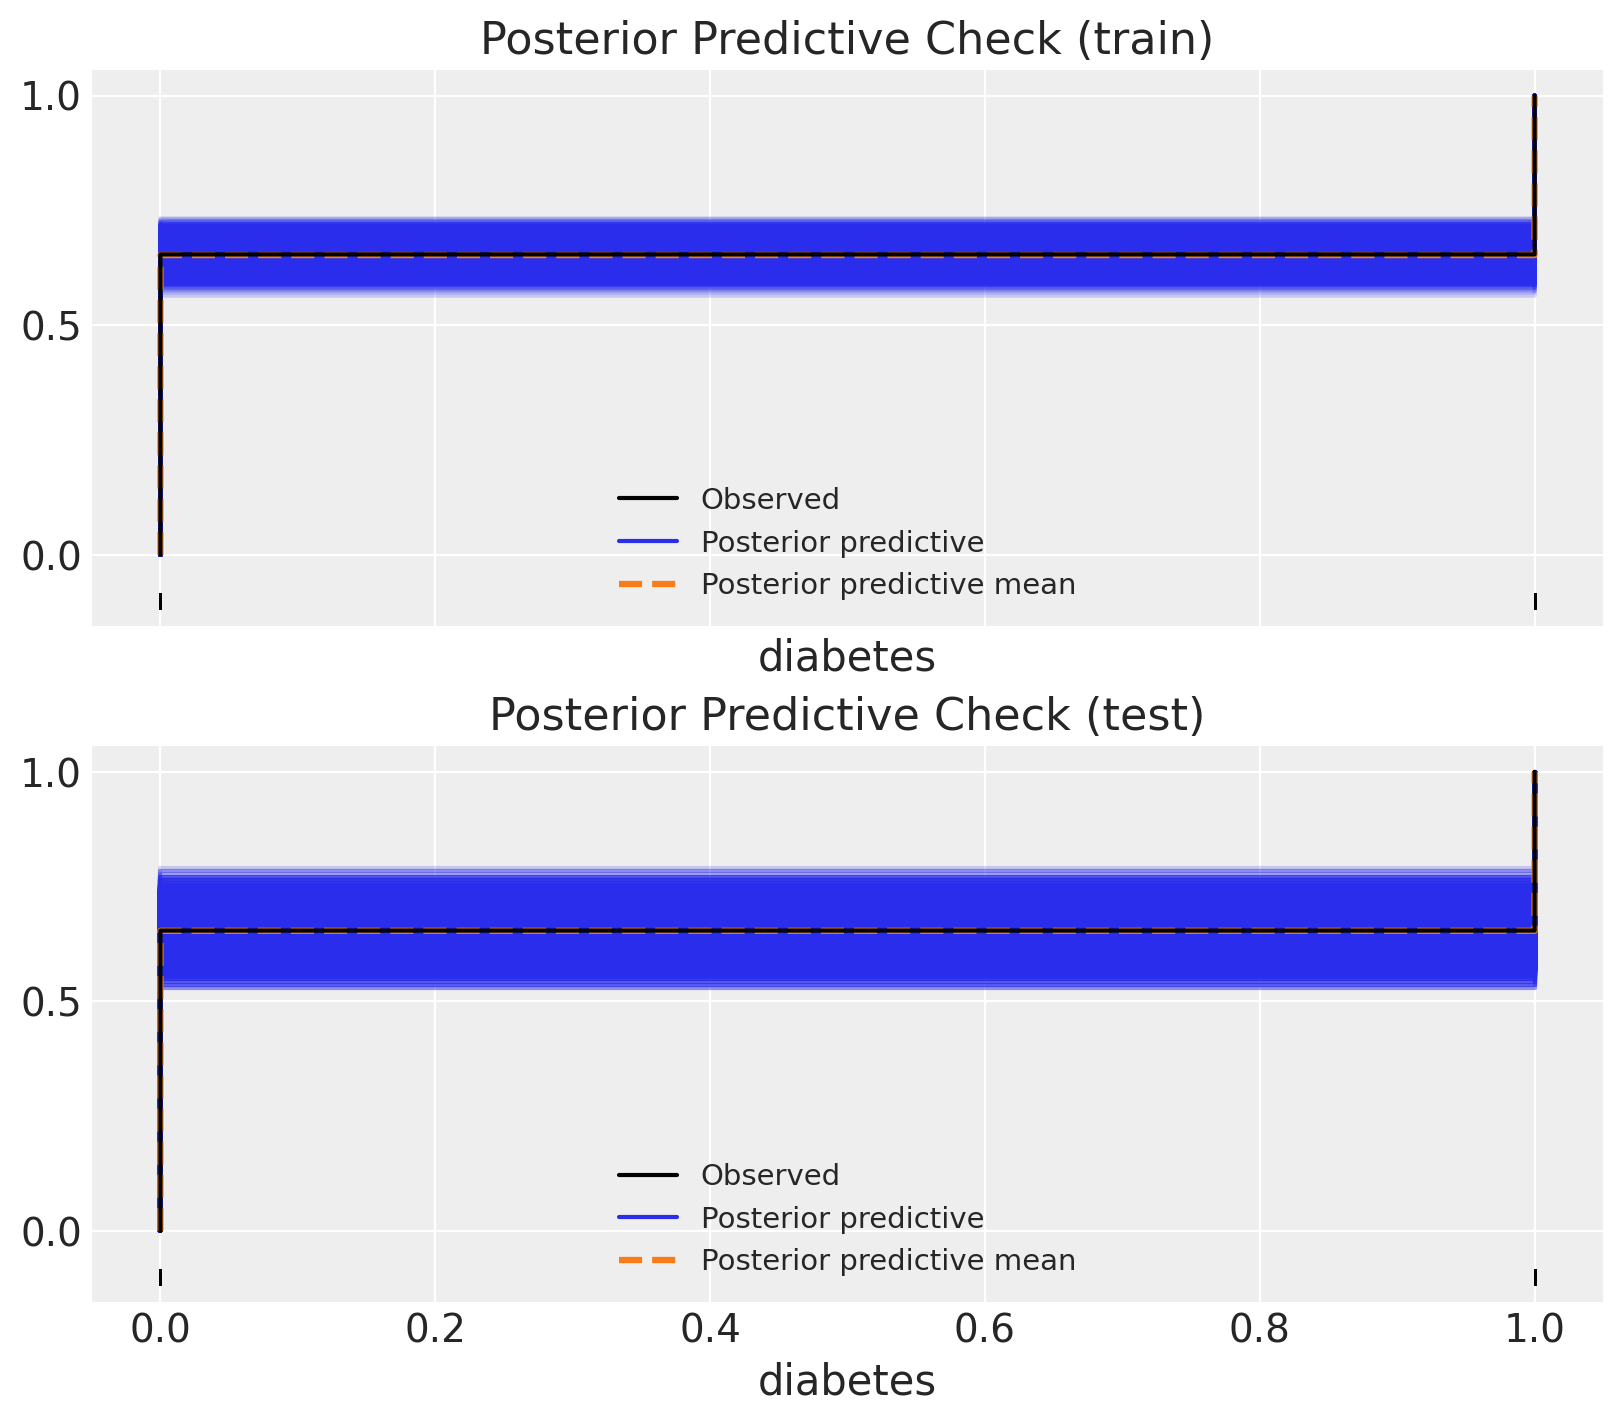

In [36]:
import arviz

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 7), sharex=True, sharey=True, layout="constrained"
)

az.plot_ppc(
    data=posterior_predictive_oos_regression_train, kind="cumulative", observed_rug=True, ax=ax[0]
)
ax[0].set(title="Posterior Predictive Check (train)")

az.plot_ppc(
    data=posterior_predictive_oos_regression_test, kind="cumulative", observed_rug=True, ax=ax[1]
)
ax[1].set(title="Posterior Predictive Check (test)")

This is a cumulative plot which means the y-axis shows the proportion of values that resulted in 0 or 1 outcomes. 

Our posterior predictive mean is somewhere in between 0.6 and 0.7 on the graph, which corresponds to $1-p$ where $p$ is the probability of the outcome being 1.

As we can see, our posterior predictive mean is almost equal to the observed value of $1-p$ for both the train and the test sets, which shows that we have a good model.

The uncertainty in the posterior predictive distribution for the test set is slightly higher than that of the train set but that is within expectations. 

In [44]:
with diabetes_model:
    print(az.summary(idata_oos_regression))

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]  0.859  0.320   0.279    1.478      0.003    0.002   14714.0   
betas[1]  0.035  0.018   0.001    0.069      0.000    0.000   16073.0   
betas[2]  0.054  0.345  -0.607    0.697      0.003    0.003   18833.0   
betas[3]  1.062  0.354   0.387    1.715      0.003    0.002   12384.0   
betas[4] -1.161  0.682  -2.391    0.151      0.006    0.004   13049.0   
...         ...    ...     ...      ...        ...      ...       ...   
p[609]    0.310  0.036   0.244    0.378      0.000    0.000   19632.0   
p[610]    0.651  0.043   0.572    0.733      0.000    0.000   15383.0   
p[611]    0.434  0.022   0.393    0.477      0.000    0.000   15086.0   
p[612]    0.267  0.024   0.223    0.313      0.000    0.000   14930.0   
p[613]    0.299  0.022   0.259    0.342      0.000    0.000   12501.0   

          ess_tail  r_hat  
betas[0]   11319.0    1.0  
betas[1]   11897.0    1.0  
betas[2]   10573.0    1.0  
betas[3]   

# Comparison with a baseline model: bayesian logistic regression

In [39]:
features = ["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure", "Glucose_Insulin_Product"]

with pm.Model() as baseline_model:
    x_data1 = pm.MutableData("x_data1", X_train)
    y_data1 = Y_train
    betas = pm.Normal('betas', mu=np.zeros(8), sigma=np.ones(8))
    mu = pm.math.dot(x_data1, betas)
    p = pm.Deterministic("p", pm.math.invprobit(mu))
    likelihood = pm.Bernoulli("likelihood", p=p, observed=y_data1, shape=(x_data1.shape[0],))
    idata_oos_regression = pm.sample(4000, tune=2000, chains=4, random_seed=RANDOM_SEED)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 254 seconds.
Sampling: [likelihood]


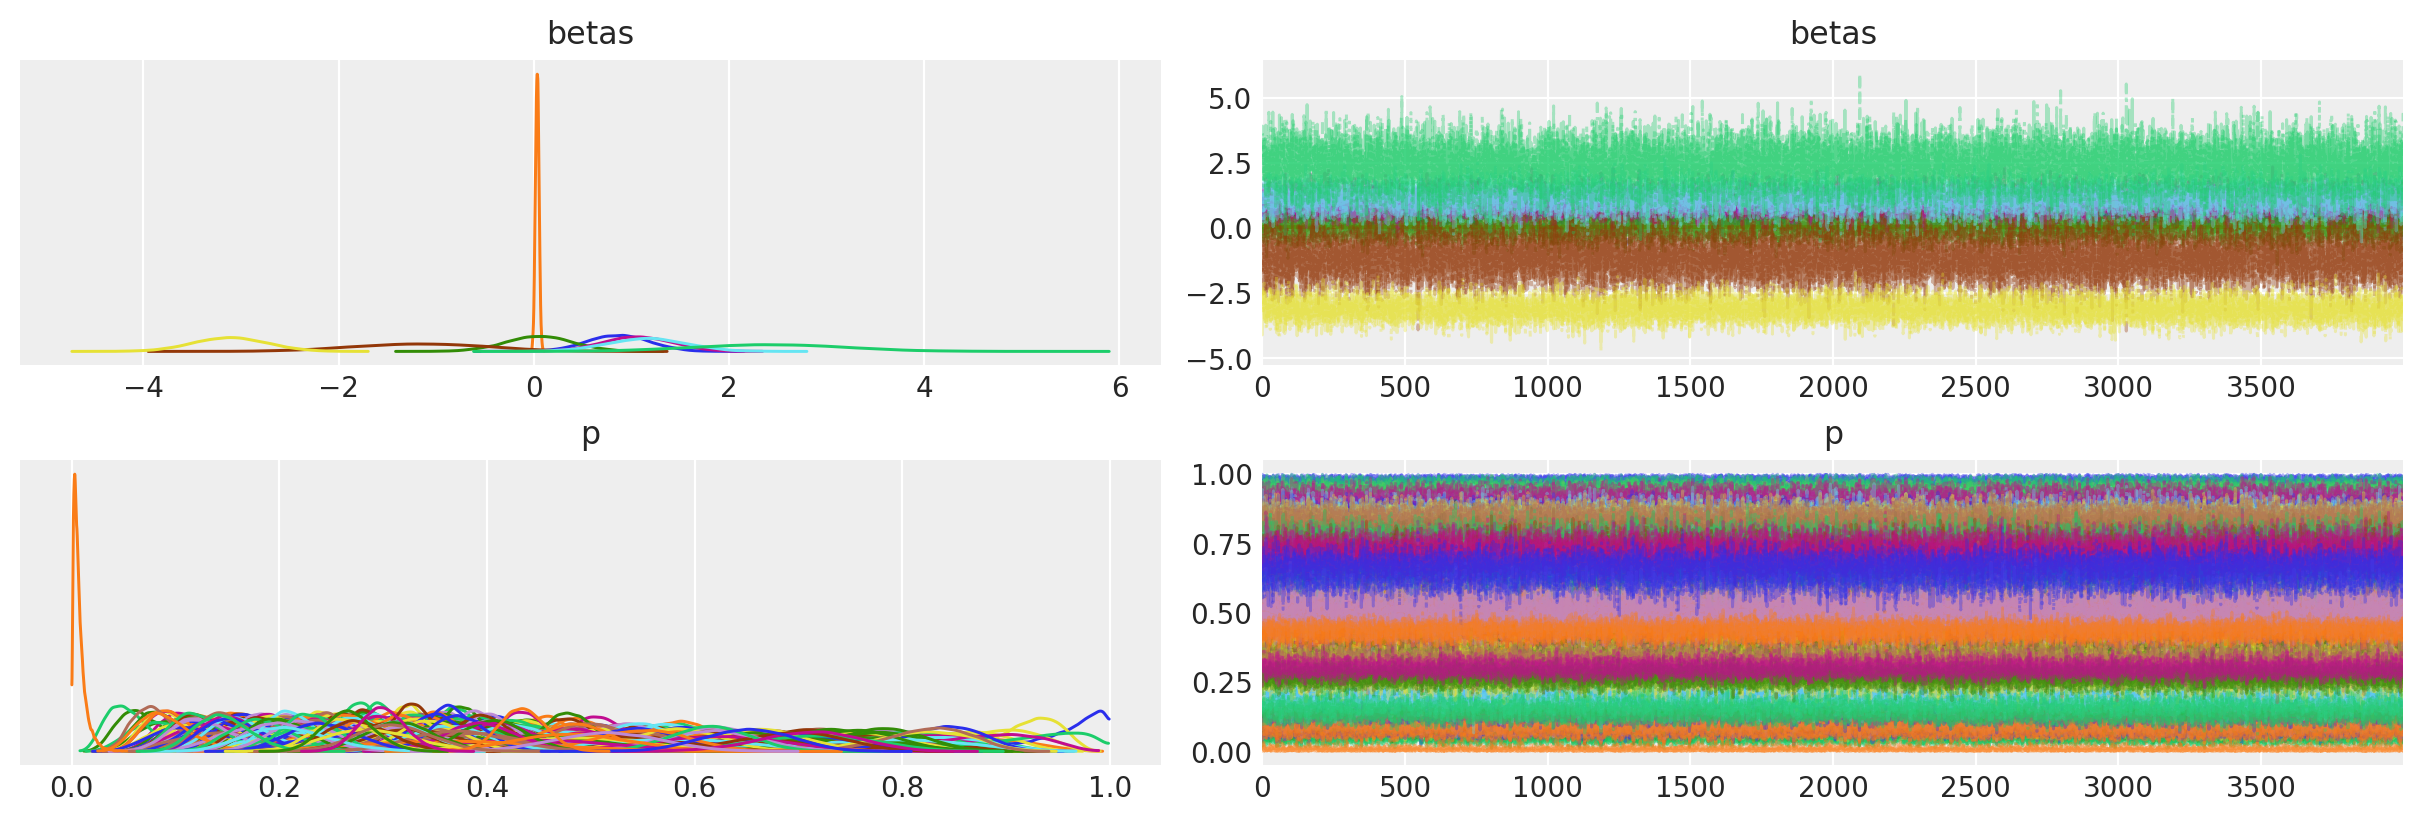

In [40]:
import arviz as az
with baseline_model:
    az.plot_trace(idata_oos_regression, combined=True)

Mixing: The chains traverse a good range of values throughout the iterations, indicating they explored the parameter space well.


Convergence: In most of the panels (corresponding to the betas), the chains appear stable after a certain number of iterations and fluctuate around a central value without showing any trends. This suggests convergence for those parameters.

In [41]:
with baseline_model:
    print(az.summary(idata_oos_regression))

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]  0.859  0.320   0.279    1.478      0.003    0.002   14714.0   
betas[1]  0.035  0.018   0.001    0.069      0.000    0.000   16073.0   
betas[2]  0.054  0.345  -0.607    0.697      0.003    0.003   18833.0   
betas[3]  1.062  0.354   0.387    1.715      0.003    0.002   12384.0   
betas[4] -1.161  0.682  -2.391    0.151      0.006    0.004   13049.0   
...         ...    ...     ...      ...        ...      ...       ...   
p[609]    0.310  0.036   0.244    0.378      0.000    0.000   19632.0   
p[610]    0.651  0.043   0.572    0.733      0.000    0.000   15383.0   
p[611]    0.434  0.022   0.393    0.477      0.000    0.000   15086.0   
p[612]    0.267  0.024   0.223    0.313      0.000    0.000   14930.0   
p[613]    0.299  0.022   0.259    0.342      0.000    0.000   12501.0   

          ess_tail  r_hat  
betas[0]   11319.0    1.0  
betas[1]   11897.0    1.0  
betas[2]   10573.0    1.0  
betas[3]   

In [42]:
with baseline_model:
    x_data1.set_value(X_test)
    y_data1 = Y_test
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Sampling: [likelihood]


s:\anaconda\envs\bart\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
s:\anaconda\envs\bart\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


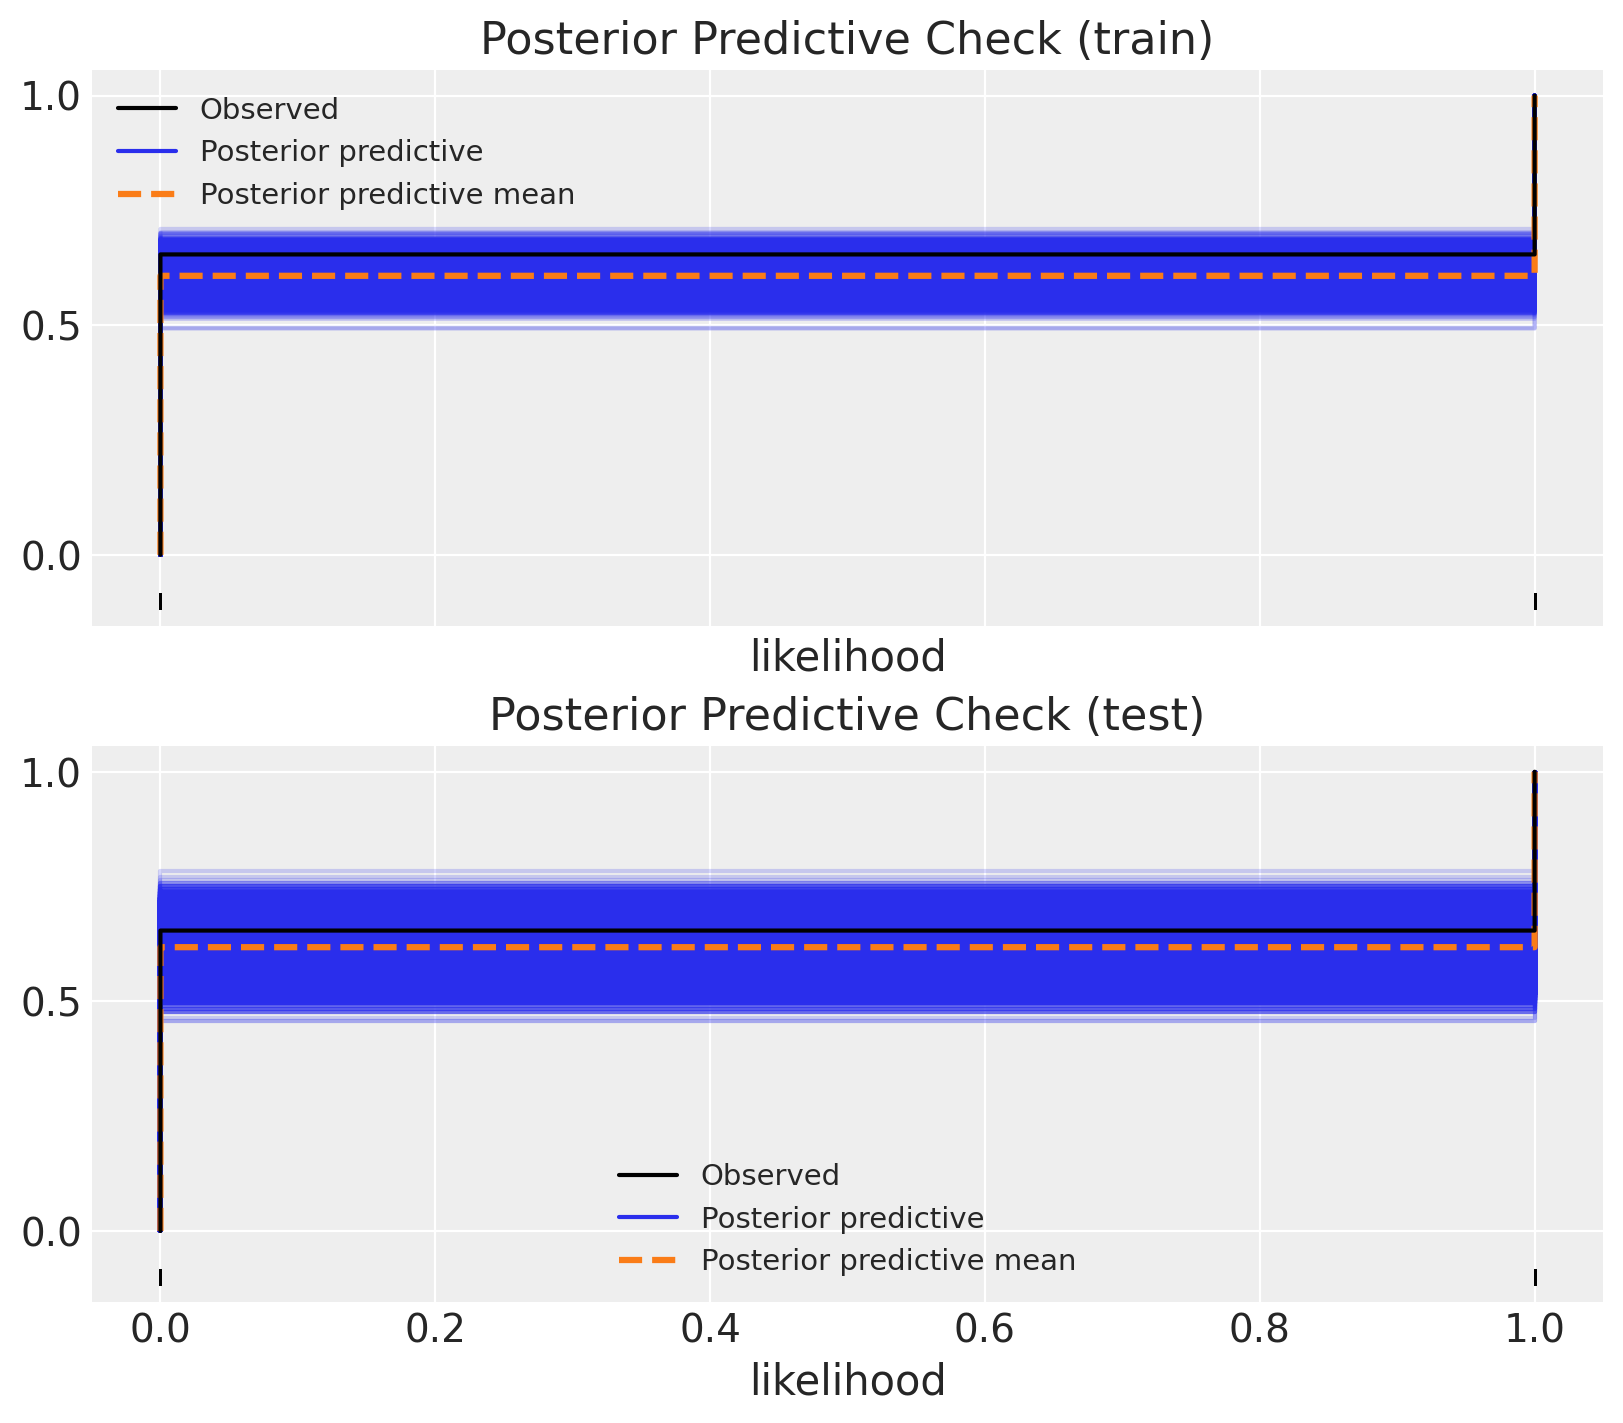

In [43]:
with baseline_model:
    
    fig, ax = plt.subplots(
        nrows=2, ncols=1, figsize=(8, 7), sharex=True, sharey=True, layout="constrained"
    )

    az.plot_ppc(
        data=posterior_predictive_oos_regression_train, kind="cumulative", observed_rug=True, ax=ax[0]
    )
    ax[0].set(title="Posterior Predictive Check (train)")

    az.plot_ppc(
        data=posterior_predictive_oos_regression_test, kind="cumulative", observed_rug=True, ax=ax[1]
    )
    ax[1].set(title="Posterior Predictive Check (test)")

Same as earlier, this is a cumulative plot which means the y-axis shows the proportion of values that resulted in 0 or 1 outcomes. 

Notice that in the baseline logistic regression model our posterior predictive mean is slightly off from the observed $1-p$ in both the train and test sets.

The posterior predictive distribution is shifted towards a slightly higher $p$ value, and although the mean is closer to the test set mean for $p$, the uncertainty in the posterior predictive distribution for the test set is a lot higher than the train set.

This is a classic example of the Bias-Variance tradeoff. The BART model is highly complex but also encorporates shrinkage via the prior on terminal nodes and therefore has low bias. There is still high variability depending on the training data
resulting in increased uncertainty for the posterior predictive distribution of unseen data in the test set.

In contrast, the baseline logistic regression model is perhaps too simple resulting in a higher bias and incorrect posterior predictive mean, but doesn't perform better in terms of uncertainty in the posterior predictive distribution for the unseen test set in comparison to BART either.

This provides us with a valid justification to prefer a more complicated approach like BART for applications in the real world where accuracy and uncertainty reduction are crucial such as predictions in the medical domain.

# References

Brian, G., Ramke, J., Page, A., Maher, L., Szetu, J., & Qoqonokana, M. Q. (2011). The association of diabetes and BMI among Melanesian and Indian Fijians aged ≥ 40 years. British Journal of Nutrition, 105(10), 1539–1545. https://doi.org/10.1017/s0007114510005258

Chipman, H. A., George, E. I., and McCulloch, R. E. (2010). “BART: Bayesian additive regression trees.” The Annals of Applied Statistics, 4(1): 266–298 https://arxiv.org/pdf/0806.3286.pdf

Connor A. Emdin, Simon G. Anderson, Mark Woodward, Kazem Rahimi,Usual Blood Pressure and Risk of New-Onset Diabetes: Evidence From 4.1 Million Adults and a Meta-Analysis of Prospective Studies,Journal of the American College of Cardiology, Volume 66, Issue 14,2015, Pages 1552-1562, ISSN 0735-1097, https://doi.org/10.1016/j.jacc.2015.07.059.

Inglis, A., Parnell, A., & Hurley, C. (2022). Visualizations for Bayesian Additive Regression Trees https://arxiv.org/pdf/2208.08966.pdf

Das, M., & Das, R. N. (2022). Explanatory Factors of Gestational Diabetes Pedigree Function of Pima Indian Heritage Women. Internal Medicine – Open Journal, 6(1), e1–e2. https://doi.org/10.17140/IMOJ-6-e002

Peters, S. A. E., Yang, L., Guo, Y., Chen, Y., Bian, Z., Sun, H., Li, Y., Li, L., Woodward, M., & Chen, Z. (2020). Pregnancy, pregnancy loss and the risk of diabetes in Chinese women: findings from the China Kadoorie Biobank. European Journal of Epidemiology, 35(3), 295–303. https://www.jstor.org/stable/48727982

Sasaki, N., Ozono, R., Higashi, Y., Maeda, R., & Kihara, Y. (2020). Association of Insulin Resistance, Plasma Glucose Level, and Serum Insulin Level With Hypertension in a Population With Different Stages of Impaired Glucose Metabolism. Journal of the American Heart Association, 9(7), e015546. https://doi.org/10.1161/JAHA.119.015546

Yan, Z., Cai, M., Han, X., Chen, Q., & Lu, H. (2023). The Interaction Between Age and Risk Factors for Diabetes and Prediabetes: A Community-Based Cross-Sectional Study. Diabetes, metabolic syndrome and obesity : targets and therapy, 16, 85–93. https://doi.org/10.2147/DMSO.S390857

Ruiz-Alejos A, Carrillo-Larco RM, Miranda JJ, Gilman RH, Smeeth L, Bernabé-Ortiz A. Skinfold thickness and the incidence of type 2 diabetes mellitus and hypertension: an analysis of the PERU MIGRANT study. Public Health Nutr. 2020 Jan;23(1):63-71. doi: 10.1017/S1368980019001307. Epub 2019 Jun 4. PMID: 31159908; PMCID: PMC6960014. https://pubmed.ncbi.nlm.nih.gov/31159908/

Okano J, Kojima H, Katagi M, Nakagawa T, Nakae Y, Terashima T, Kurakane T, Kubota M, Maegawa H, Udagawa J. Hyperglycemia Induces Skin Barrier Dysfunctions with Impairment of Epidermal Integrity in Non-Wounded Skin of Type 1 Diabetic Mice. PLoS One. 2016 Nov 15;11(11):e0166215. doi: 10.1371/journal.pone.0166215. PMID: 27846299; PMCID: PMC5113047. https://pubmed.ncbi.nlm.nih.gov/27846299/


